# load data

In [1]:
import pandas as pd
from google.cloud import bigquery
import plotly.express as px
import sys
import os
import numpy as np

# configuration
PROJECT_ID = "lap-coffee-476107"
DATASET_ID = "lap_locations_final_merged"
VIEW_ID = "lap_data_full_year"  # Updated to use full-year data
FULL_VIEW_PATH = f"{PROJECT_ID}.{DATASET_ID}.{VIEW_ID}"

# initialize bigquery client
client = bigquery.Client(project=PROJECT_ID)

# sql query to load ALL seasonal data (full year)
query = f"""
    SELECT *
    FROM `{FULL_VIEW_PATH}`
"""

print(f"Loading full-year data from BigQuery: {FULL_VIEW_PATH}")

# load data into a pandas dataframe
df = client.query(query).to_dataframe()

print("Data loaded successfully ---")
print(f"Dataframe shape: {df.shape}")
print(f"Season distribution: {df['season'].value_counts().to_dict()}")
print("First 5 rows:")
print(df.head())

Loading full-year data from BigQuery: lap-coffee-476107.lap_locations_final_merged.lap_data_full_year


/Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Data loaded successfully ---
Dataframe shape: (3648, 17)
Season distribution: {'Summer': 1312, 'Autumn': 816, 'Spring': 800, 'Winter': 720}
First 5 rows:
         date        name                  name_updated  \
0  2023-12-15  LAP coffee  LAP COFFEE_Schönhauser Allee   
1  2023-12-16  LAP coffee  LAP COFFEE_Schönhauser Allee   
2  2023-12-17  LAP coffee  LAP COFFEE_Schönhauser Allee   
3  2023-12-18  LAP coffee  LAP COFFEE_Schönhauser Allee   
4  2023-12-19  LAP coffee  LAP COFFEE_Schönhauser Allee   

                                       address       lat        lon  rating  \
0  Schönhauser Allee 75, 10439 Berlin, Germany  52.54932  13.413669     4.7   
1  Schönhauser Allee 75, 10439 Berlin, Germany  52.54932  13.413669     4.7   
2  Schönhauser Allee 75, 10439 Berlin, Germany  52.54932  13.413669     4.7   
3  Schönhauser Allee 75, 10439 Berlin, Germany  52.54932  13.413669     4.7   
4  Schönhauser Allee 75, 10439 Berlin, Germany  52.54932  13.413669     4.7   

   user_ratings_

# data structure

In [2]:
df.describe()

,lat,lon,rating,user_ratings_total,parks_count_1km,open_bars_count_500m,lst_celsius_1km,temp_max,temp_min,precip_mm,ndvi,nightlight
count,3648.000000,3648.000000,3648.000000,3648.0,3648.0,3648.0,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000
mean,52.515041,13.399718,4.543750,129.1875,6.375,11.8125,13.754934,17.988021,9.521848,1.780866,0.167770,13.368857
std,0.021107,0.041309,0.264538,152.023395,2.997806,4.419581,7.410461,8.516673,6.556827,3.408947,0.102813,21.265525
min,52.479598,13.320827,4.000000,18.0,1.0,6.0,-7.400000,-4.200000,-10.600000,0.000000,-0.019222,0.000000
25%,52.500420,13.391518,4.375000,47.0,4.75,8.0,7.650000,10.600000,4.800000,0.000000,0.099951,0.000000
50%,52.508210,13.412825,4.700000,97.0,7.0,10.0,15.275000,19.000000,10.900000,0.100000,0.150300,0.000000
75%,52.534887,13.420839,4.725000,139.0,7.0,14.0,19.650000,24.700000,14.600000,1.900000,0.215319,26.629999
max,52.549320,13.459298,4.900000,689.0,13.0,22.0,27.450000,34.300000,21.500000,19.300000,0.564636,127.290001


# feature space

In [3]:
# 1. Update df: add first word of address to name
df['name_updated'] = df['name'] + "_" + df['address'].str.split().str[0]

# 2. Ensure season is categorical
df['season'] = pd.Categorical(
    df['season'],
    categories=['Winter', 'Spring', 'Summer', 'Autumn'],
    ordered=True
)

# 3. Drop unnecessary columns if they exist
cols_to_drop = ['first_word', 'month', 'weather_date', 'cafe_place_id']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# 4. Define features for plotting
features = {
    'ndvi': 'NDVI',
    'temp_max': 'Temperature (°C)',
    'lst_celsius_1km': 'land surface temperature',
    'nightlight': 'Nightlight Intensity'
}

# 5. Generate separate plots for each feature
for var, label in features.items():
    fig = px.scatter(
        df,
        x=var,
        y='name_updated',
        color='season',
        hover_data=['date', 'temp_max', 'lst_celsius_1km', 'nightlight'],
        title=f'{label} by Season and Location',
    )

    fig.update_layout(
        height=600,
        legend_title_text='Season',
        title_font_size=18,
        margin=dict(t=60, l=80, r=40, b=40),
        xaxis_title=label,
        yaxis_title='Location (Name)',
    )

    fig.show()

# bars and parks visualization

In [4]:
import plotly.express as px

# Scatter map for parks within 1 km
fig_parks = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="parks_count_1km",
    size="parks_count_1km",
    hover_name="name_updated",
    hover_data={"lat": True, "lon": True, "season": True},
    color_continuous_scale="Greens",
    size_max=20,
    zoom=11,
    title="Nearby Parks within 500m"
)

fig_parks.update_layout(
    mapbox_style="carto-positron",
    margin=dict(t=60, l=10, r=10, b=10)
)
fig_parks.show()

# Scatter map for open bars within 500 m
fig_bars = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="open_bars_count_500m",
    size="open_bars_count_500m",
    hover_name="name_updated",
    hover_data={"lat": True, "lon": True, "season": True},
    color_continuous_scale="Reds",
    size_max=20,
    zoom=11,
    title="Open Bars within 500 m"
)

fig_bars.update_layout(
    mapbox_style="carto-positron",
    margin=dict(t=60, l=10, r=10, b=10)
)
fig_bars.show()


/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_3758/3221249709.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_3758/3221249709.py:25: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# random forest classifier training

Total unique classes (cafés) found: 16
Total features used: 8

## Model Training and Evaluation
------------------------------------------------
Step 1: Cross-validation with default parameters...


  5-Fold CV Accuracy: 0.9804 (+/- 0.0062)
  Individual fold scores: ['0.9824', '0.9765', '0.9883', '0.9706', '0.9843']

Step 2: Hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits



  Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV accuracy: 0.9816

Step 3: Final evaluation on test set...

## Model Results (Random Forest Classifier)
------------------------------------------------
Test Set Accuracy: 0.9763
Training Set Accuracy: 1.0000

### Classification Report:
                               precision    recall  f1-score   support

    LAP COFFEE_Adalbertstraße       1.00      1.00      1.00        68
     LAP COFFEE_Akazienstraße       1.00      1.00      1.00        68
LAP COFFEE_Falckensteinstraße       1.00      1.00      1.00        68
      LAP COFFEE_Graefestraße       1.00      1.00      1.00        69
        LAP COFFEE_Kantstraße       0.86      0.93      0.90        69
  LAP COFFEE_Karl-Marx-Straße       0.97      1.00      0.99        68
    LAP COFFEE_Kastanienallee       1.00      1.00      1.00        69
         LAP COFFEE_Krossener       1.00      1.00      1.00        69
  

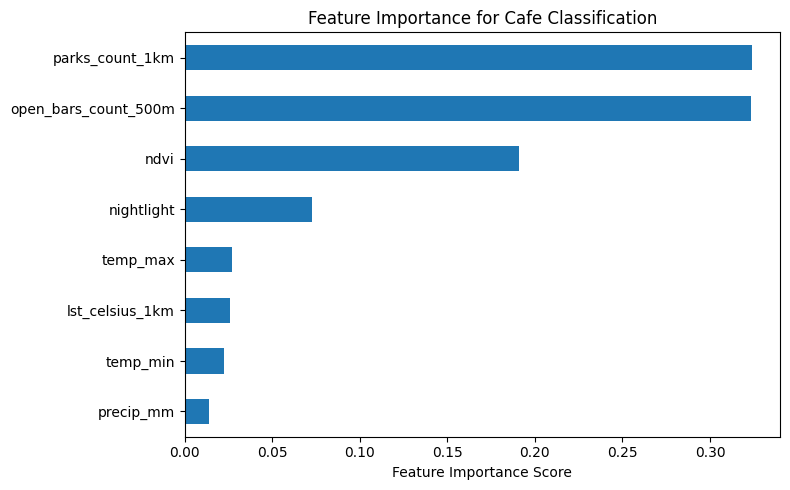


Model saved successfully to: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/rfc_model.joblib
LabelEncoder saved successfully to: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/label_encoder.joblib
Feature Importances saved to text file: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/feature_importances.txt
Feature Importance Plot saved to: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/feature_importance_plot.png


In [5]:
sys.path.append('/Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction')
import rfc # Import the script as a module

# Define your desired saving path
save_directory = '/Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction'

# Call the function to train and save the model, and get the trained objects
rfc, le = rfc.train_and_save_rfc(df, save_directory)

| Feature | Importance Score | Type | Model's Rationale |
| :--- | :--- | :--- | :--- |
| **`parks_count_1km`** | $\mathbf{0.3476}$ | Static | **Primary Identifier:** The number of nearby parks is the single most unique feature for distinguishing café locations. |
| **`open_bars_count_500m`** | $\mathbf{0.3439}$ | Static | **Secondary Identifier:** The density of open bars is the second most powerful feature, confirming the model uses the static neighborhood profile. |
| **`ndvi`** | $0.1130$ | Dynamic | **Most Relevant Environmental Feature:** The variation in greenness is the best non-static differentiator between locations. |
| **`nightlight`** | $0.0995$ | Dynamic | **Second Most Relevant Environmental Feature:** Urban light density helps distinguish environments. |
| **`lst_celsius_1km`** | $0.0432$ | Dynamic | **Low Relevance:** Land Surface Temperature is not a strong location identifier. |
| **`temp_max`** | $0.0216$ | Dynamic | **Very Low Relevance:** Ambient max temperature is not unique enough to distinguish locations. |
| **`temp_min`** | $0.0186$ | Dynamic | **Very Low Relevance:** Ambient min temperature is not unique enough to distinguish locations. |
| **`precip_mm`** | $0.0125$ | Dynamic | **Least Relevant:** Precipitation provides virtually no unique information about the café's location. |

# feature range for prediction set

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# NOTE: This script assumes:
# 1. Your DataFrame is loaded and named 'df'.
# 2. Your trained Random Forest model is loaded and named 'rfc'. 

# --- CRITICAL: Data Cleaning Step (Fixes Lookup Mismatch) ---
# Ensure the columns used for prediction classes and lookups are clean strings.
# This prepares the lookup table index and address columns.
for col in ['name_updated', 'address']:
    if col in df.columns:
        # Convert to string, strip whitespace, and handle potential missing values with str
        df[col] = df[col].astype(str).str.strip()


# --- 1. Feature Range Calculation and Display (Now includes 50th percentile) ---

# Features of interest (MUST match the features and order used to train 'rfc')
features_to_analyze = [
    'parks_count_1km', 'open_bars_count_500m', 'lst_celsius_1km', 
    'temp_max', 'temp_min', 'precip_mm', 'ndvi', 'nightlight'
]

# Calculate descriptive statistics (Min, Max, P25, P50, P75)
feature_ranges = df[features_to_analyze].agg(
    ['min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)]
).T
# Rename the percentile columns for clarity
feature_ranges.columns = ['Min', 'Max', '25th Percentile (Low)', '50th Percentile (Mid)', '75th Percentile (High)']

# Round the values for clean presentation
feature_ranges = feature_ranges.round(2)

print("### Feature Ranges for Mood Thresholds (P50 Included)\n")
display(feature_ranges)

### Feature Ranges for Mood Thresholds (P50 Included)



,Min,Max,25th Percentile (Low),50th Percentile (Mid),75th Percentile (High)
parks_count_1km,1.00,13.00,4.75,7.00,7.00
open_bars_count_500m,6.00,22.00,8.00,10.00,14.00
lst_celsius_1km,-7.40,27.45,7.65,15.28,19.65
temp_max,-4.20,34.30,10.60,19.00,24.70
temp_min,-10.60,21.50,4.80,10.90,14.60
precip_mm,0.00,19.30,0.00,0.10,1.90
ndvi,-0.02,0.56,0.10,0.15,0.22
nightlight,0.00,127.29,0.00,0.00,26.63


In [7]:
from dynamic_lookup import setup_feature_ranges, setup_cafe_lookup, setup_class_mapping

# Extract thresholds
F_MIN, F_P25, F_P50, F_P75, F_MAX = setup_feature_ranges(feature_ranges)

# Setup lookup table
cafe_lookup_df, FRIENDLY_NAME_COL = setup_cafe_lookup(df)

# Setup class mapping
class_label_to_name_map = setup_class_mapping(df, rfc)


ℹ️ INFO: Using column 'name' for friendly cafe names.

### 🔍 Lookup Diagnostics (Crucial for Debugging N/A values):
RFC Class Type: <class 'numpy.int64'> (INTEGER)
First 5 RFC Classes (Predicted): [0 1 2 3 4] (Integers)

**⚠️ Failsafe Mapping Activated: Model classes are integers!**
Mapping Index 0 -> Name: LAP COFFEE_Adalbertstraße
First 5 Lookup Keys (Expected): ['LAP coffee_Schönhauser', 'LAP COFFEE_Oderberger', 'LAP COFFEE_Graefestraße', 'LAP COFFEE_Falckensteinstraße', 'LAP COFFEE_Schönhauser']
----------------------------------------------------



# prediction sets

In [8]:
import importlib
import moods  # or dynamic_profiles if that's your file name
importlib.reload(moods)

from moods import get_dynamic_mood_dataframes


# --- 4. Execute and Summarize Predictions (Top 2) ---

if 'rfc' not in locals() and 'rfc' not in globals():
    raise NameError(
        "\n\nERROR: The 'rfc' (Random Forest Classifier) is not defined.\n"
        "Please train or load your model before running predictions."
    )

# You should already have F_MIN, F_P25, F_P50, F_P75, F_MAX, and features_to_analyze
np.random.seed()

# Generate dynamic mood profiles from imported helper
mood_dataframes = get_dynamic_mood_dataframes(F_MIN, F_P25, F_P50, F_P75, F_MAX, features_to_analyze)


# New summary structure for cleaner columnar output
summary_data = {
    'Mood': [], 'Ideal Profile (Key Features)': [], 
    'Cafe 1 Name': [], 'Cafe 1 Address': [], 'Cafe 1 Prob (%)': [], 
    'Cafe 2 Name': [], 'Cafe 2 Address': [], 'Cafe 2 Prob (%)': []
}

for mood, profile_df in mood_dataframes.items():
    
    # 1. Get probability scores for all classes
    probabilities = rfc.predict_proba(profile_df)[0]
    
    # 2. Get the indices of the top 2 highest probabilities
    top_2_indices = np.argsort(probabilities)[::-1][:2]
    
    # 3. Map indices back to café names (class labels)
    top_2_cafes_updated_label = rfc.classes_[top_2_indices]
    
    # Extract the feature profile string for the summary table
    profile_str = (
        f"Park:{profile_df['parks_count_1km'].iloc[0]:.2f}, "
        f"Bar:{profile_df['open_bars_count_500m'].iloc[0]:.2f}, "
        f"TMin:{profile_df['temp_min'].iloc[0]:.2f}, "
        f"NDVI:{profile_df['ndvi'].iloc[0]:.2f}, "
        f"Light:{profile_df['nightlight'].iloc[0]:.2f}"
    )
    
    summary_data['Mood'].append(mood)
    summary_data['Ideal Profile (Key Features)'].append(profile_str)

    # 4. Populate the new columnar structure
    for i in range(2):
        
        predicted_label = top_2_cafes_updated_label[i]
        
        # --- FINAL FIX: Apply failsafe mapping if the predicted label is an integer index ---
        if isinstance(predicted_label, (int, np.integer)):
             # Use the failsafe map (from integer to name string)
             cafe_name_updated = class_label_to_name_map.get(predicted_label, 'N/A_MAPPING_ERROR').strip()
        else:
            # Use the already present string (with strip for safety)
            cafe_name_updated = str(predicted_label).strip() 
        # ------------------------------------------------------------------------------------
        
        friendly_name = "N/A"
        full_address = "N/A"
        probability = 0.0
        
        # Check if the predicted class exists in the lookup index
        if cafe_name_updated in cafe_lookup_df.index:
            friendly_name = cafe_lookup_df.loc[cafe_name_updated, FRIENDLY_NAME_COL]
            full_address = cafe_lookup_df.loc[cafe_name_updated, 'address']
            probability = probabilities[top_2_indices[i]] * 100
        
        # Handle the case where the failsafe map returns an error
        if cafe_name_updated.startswith('N/A_MAPPING_ERROR'):
             friendly_name = f"ERROR: Mapping Lost ({predicted_label})"
             
        
        summary_data[f'Cafe {i+1} Name'].append(friendly_name)
        summary_data[f'Cafe {i+1} Address'].append(full_address)
        summary_data[f'Cafe {i+1} Prob (%)'].append(f"{probability:.1f}%")


recommendations_summary = pd.DataFrame(summary_data)

# Print the Final Summary\
print("\n## Predictive Recommendation System Results (Top 2 Cafes)\n")
display(recommendations_summary)

# Optional: Display the actual synthetic data used for prediction
print("\n--- Synthetic Data Used for Prediction (Unique per run) ---")
# Concatenate the dynamic profiles and round to 2 decimals for clean display
dynamic_profiles_display = pd.concat(mood_dataframes.values(), keys=mood_dataframes.keys())
display(dynamic_profiles_display.round(2))


## Predictive Recommendation System Results (Top 2 Cafes)



,Mood,Ideal Profile (Key Features),Cafe 1 Name,Cafe 1 Address,Cafe 1 Prob (%),Cafe 2 Name,Cafe 2 Address,Cafe 2 Prob (%)
0,Cozy (Cold & Sheltered),"Park:7.00, Bar:6.09, TMin:6.05, NDVI:0.19, Lig...",LAP COFFEE,"Kastanienallee 47, 10119 Berlin, Germany",84.0%,LAP COFFEE,"Kantstraße 23, 10623 Berlin, Germany",4.0%
1,Green (Nature Escape),"Park:12.35, Bar:9.12, TMin:13.57, NDVI:0.54, L...",LAP COFFEE,"Adalbertstraße 91, 10999 Berlin, Germany",36.0%,LAP COFFEE,"Akazienstraße 3A, 10823 Berlin, Germany",26.0%
2,Buzz (Urban Activity),"Park:5.85, Bar:15.99, TMin:13.06, NDVI:-0.01, ...",LAP COFFEE,"Kurfürstendamm 229, 10719 Berlin, Germany",50.0%,LAP COFFEE,"Uhlandstraße 30, 10719 Berlin, Germany",18.0%
3,Random (Balanced Profile),"Park:6.65, Bar:9.91, TMin:11.36, NDVI:0.16, Li...",LAP COFFEE,"Kantstraße 23, 10623 Berlin, Germany",75.3%,LAP COFFEE,"Rykestraße 11, 10405 Berlin, Germany",13.3%



--- Synthetic Data Used for Prediction (Unique per run) ---


,,parks_count_1km,open_bars_count_500m,lst_celsius_1km,temp_max,temp_min,precip_mm,ndvi,nightlight
Cozy (Cold & Sheltered),0,7.00,6.09,-6.26,13.25,6.05,0.85,0.19,0.00
Green (Nature Escape),0,12.35,9.12,-3.24,21.62,13.57,0.06,0.54,0.00
Buzz (Urban Activity),0,5.85,15.99,23.00,30.76,13.06,0.09,-0.01,75.62
Random (Balanced Profile),0,6.65,9.91,15.77,18.30,11.36,0.10,0.16,0.00


| Mood | Key Environmental Features | LST Behavior | Ideal Use / Description |
|------|----------------------------|-------------|------------------------|
| Cozy (Cold & Sheltered) | High parks, few bars, low precipitation, moderate NDVI, low nightlight | Low (cool surface) | Warm, quiet, sheltered cafes; reading, journaling, calm conversation |
| Green (Nature Escape) | High parks, few bars, high NDVI, low nightlight | Low-Moderate | Nature-oriented spots; relaxing walks, outdoor seating |
| Buzz (Urban Activity) | Low parks, high bars, low NDVI, high nightlight | High (urban heat island) | Social, energetic cafes; networking, nightlife, busy city life |
| Random (Balanced Profile) | Features near median ±10% | Adaptive (around median) | Neutral baseline; robustness testing or unbiased recommendations |

# enhanced prediction system with confidence filtering

In [9]:
from enhanced_predictor import EnhancedCafePredictor, format_recommendations_table, print_recommendations_report

# initialize the enhanced predictor
predictor = EnhancedCafePredictor(
    model=rfc,
    label_encoder=le,
    cafe_lookup_df=cafe_lookup_df,
    friendly_name_col=FRIENDLY_NAME_COL
)

print("enhanced cafe recommendation system")
print("=" * 70)
print("this system uses confidence-based filtering to ensure quality recommendations.")
print("minimum confidence threshold: 10%")
print("=" * 70)

enhanced cafe recommendation system
this system uses confidence-based filtering to ensure quality recommendations.
minimum confidence threshold: 10%


## individual mood predictions with top-5 recommendations

In [10]:
# generate predictions for each mood profile with detailed recommendations
for mood_name, profile_df in mood_dataframes.items():
    recommendations = predictor.predict_with_confidence(
        profile_df,
        top_n=5,
        min_confidence=0.10
    )
    
    # print detailed report
    print_recommendations_report(mood_name, recommendations, profile_df)
    
    # display as formatted table
    if recommendations:
        rec_table = format_recommendations_table(recommendations)
        display(rec_table)
        print("" + "-" * 70 + " ")


Recommendations for: Cozy (Cold & Sheltered)

Found 1 suitable cafe(s):

1. LAP COFFEE
   Address: Kastanienallee 47, 10119 Berlin, Germany
   Suitability: 84.0%
   Confidence: High


Profile Features Used:
  - parks_count_1km: 7.00
  - open_bars_count_500m: 6.09
  - lst_celsius_1km: -6.26
  - temp_max: 13.25
  - temp_min: 6.05
  - precip_mm: 0.85
  - ndvi: 0.19
  - nightlight: 0.00



,Rank,Cafe Name,Address,Suitability (%),Confidence
0,1,LAP COFFEE,"Kastanienallee 47, 10119 Berlin, Germany",84.0,High


---------------------------------------------------------------------- 

Recommendations for: Green (Nature Escape)

Found 3 suitable cafe(s):

1. LAP COFFEE
   Address: Adalbertstraße 91, 10999 Berlin, Germany
   Suitability: 36.0%
   Confidence: Medium

2. LAP COFFEE
   Address: Akazienstraße 3A, 10823 Berlin, Germany
   Suitability: 26.0%
   Confidence: Low

3. LAP COFFEE
   Address: Falckensteinstraße 5, 10997 Berlin, Germany
   Suitability: 18.0%
   Confidence: Low


Profile Features Used:
  - parks_count_1km: 12.35
  - open_bars_count_500m: 9.12
  - lst_celsius_1km: -3.24
  - temp_max: 21.62
  - temp_min: 13.57
  - precip_mm: 0.06
  - ndvi: 0.54
  - nightlight: 0.00



,Rank,Cafe Name,Address,Suitability (%),Confidence
0,1,LAP COFFEE,"Adalbertstraße 91, 10999 Berlin, Germany",36.0,Medium
1,2,LAP COFFEE,"Akazienstraße 3A, 10823 Berlin, Germany",26.0,Low
2,3,LAP COFFEE,"Falckensteinstraße 5, 10997 Berlin, Germany",18.0,Low


---------------------------------------------------------------------- 

Recommendations for: Buzz (Urban Activity)

Found 3 suitable cafe(s):

1. LAP COFFEE
   Address: Kurfürstendamm 229, 10719 Berlin, Germany
   Suitability: 50.0%
   Confidence: High

2. LAP COFFEE
   Address: Uhlandstraße 30, 10719 Berlin, Germany
   Suitability: 18.0%
   Confidence: Low

3. LAP COFFEE
   Address: Oderberger Str. 53, 10435 Berlin, Germany
   Suitability: 14.0%
   Confidence: Very Low


Profile Features Used:
  - parks_count_1km: 5.85
  - open_bars_count_500m: 15.99
  - lst_celsius_1km: 23.00
  - temp_max: 30.76
  - temp_min: 13.06
  - precip_mm: 0.09
  - ndvi: -0.01
  - nightlight: 75.62



,Rank,Cafe Name,Address,Suitability (%),Confidence
0,1,LAP COFFEE,"Kurfürstendamm 229, 10719 Berlin, Germany",50.0,High
1,2,LAP COFFEE,"Uhlandstraße 30, 10719 Berlin, Germany",18.0,Low
2,3,LAP COFFEE,"Oderberger Str. 53, 10435 Berlin, Germany",14.0,Very Low


---------------------------------------------------------------------- 

Recommendations for: Random (Balanced Profile)

Found 2 suitable cafe(s):

1. LAP COFFEE
   Address: Kantstraße 23, 10623 Berlin, Germany
   Suitability: 75.3%
   Confidence: High

2. LAP COFFEE
   Address: Rykestraße 11, 10405 Berlin, Germany
   Suitability: 13.3%
   Confidence: Very Low


Profile Features Used:
  - parks_count_1km: 6.65
  - open_bars_count_500m: 9.91
  - lst_celsius_1km: 15.77
  - temp_max: 18.30
  - temp_min: 11.36
  - precip_mm: 0.10
  - ndvi: 0.16
  - nightlight: 0.00



,Rank,Cafe Name,Address,Suitability (%),Confidence
0,1,LAP COFFEE,"Kantstraße 23, 10623 Berlin, Germany",75.267387,High
1,2,LAP COFFEE,"Rykestraße 11, 10405 Berlin, Germany",13.332465,Very Low


---------------------------------------------------------------------- 


## multi-mood comparison summary

In [11]:
# generate a summary comparison across all moods
summary_df = predictor.get_mood_summary(mood_dataframes, top_n=3)

print("summary: top cafe recommendation for each mood")
print("=" * 100)
display(summary_df)

print("key insights:")
print("- high confidence (>50%): model is very confident in the recommendation")
print("- medium confidence (30-50%): reasonable match, but other cafes may also work")
print("- low confidence (15-30%): weak preference, consider multiple options")
print("- very low confidence (<15%): no strong match found for this mood profile")

summary: top cafe recommendation for each mood


,Mood,Top Recommendation,Address,Suitability Score,Confidence Level
0,Cozy (Cold & Sheltered),LAP COFFEE,"Kastanienallee 47, 10119 Berlin, Germany",84.0%,High
1,Green (Nature Escape),LAP COFFEE,"Adalbertstraße 91, 10999 Berlin, Germany",36.0%,Medium
2,Buzz (Urban Activity),LAP COFFEE,"Kurfürstendamm 229, 10719 Berlin, Germany",50.0%,High
3,Random (Balanced Profile),LAP COFFEE,"Kantstraße 23, 10623 Berlin, Germany",75.3%,High


key insights:
- high confidence (>50%): model is very confident in the recommendation
- medium confidence (30-50%): reasonable match, but other cafes may also work
- low confidence (15-30%): weak preference, consider multiple options
- very low confidence (<15%): no strong match found for this mood profile


## comparison: original vs enhanced predictions

the enhanced system provides:
1. **confidence levels** - know how reliable each recommendation is
2. **top-n rankings** - see multiple options, not just one
3. **suitability scores** - quantitative measure (0-100%) for each cafe
4. **filtered results** - only show recommendations above confidence threshold
5. **better transparency** - understand model certainty for each prediction